# Tweet Sentiment Analysis For SXSW 2012

Perorming a sentiment analysis of over 9000 tweets sent during the 2012 South by Southerwest festival in order to gain insight into recommendations for future events.

In [3]:
import nltk
import spacy
import string

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import plotly.express    as px

from matplotlib import cm
from tqdm       import tqdm
from wordcloud  import WordCloud


from nltk.probability import FreqDist
from nltk.corpus      import stopwords
from nltk.tokenize    import sent_tokenize, word_tokenize
from nltk.stem        import PorterStemmer, WordNetLemmatizer

from imblearn.combine        import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn         import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, make_scorer, accuracy_score

from sklearn.preprocessing           import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection         import train_test_split, GridSearchCV

from sklearn.naive_bayes   import MultinomialNB, GaussianNB
from sklearn.ensemble      import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble      import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.svm           import SVC

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/jojo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jojo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jojo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/jojo/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Preprocessing & Cleaning

In our initial analysis we found a very large amount of NaN data but on further inspection it was clear that most of it was in a column that we were not intending to use. It therefore made sense to drop the column all together in order to preserve the maximum amount of data we can work with.

In [4]:
df_raw = pd.read_csv('data/tweet_product_company.csv', encoding = 'unicode_escape')
df_raw.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [5]:
df_raw.drop(axis=1, columns='emotion_in_tweet_is_directed_at', inplace=True)
df_raw.dropna(inplace=True)
df_raw.shape

(9092, 2)

### Creating Binary Database

For our initial modeling we wanted to review only the positive and negative sentiments. To do this we created what we called a 'Binary' Database with only those two sentiments.

In [6]:
df1 = df_raw[df_raw['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']
df2 = df_raw[df_raw['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']
df  = pd.concat([df1,df2])
df.shape

(3548, 2)

### Creating Tertiary Database

We also wanted to try our models with the neutral sentiments to see how they would differ which is why we also created a 'Tertiary' Database that included the neutral tweets.

In [7]:
df_raw['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [8]:
df3    = df_raw[df_raw['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']
df_tri = pd.concat([df, df3])
df_tri.shape

(8936, 2)

## EDA

For our EDA we wanted to get an overview of the data we were dealing with. To do this we utlized:
- Emotion Counts
- Most Frequant Words(in all 3 catagories)
- Top Words in all 3 catagories
- Top Word Frequencies

### Emotion Counts

In [9]:
df_tri.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

### Most Frequent Words

In [10]:
df_freq_positive = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']
df_freq_negative = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']
df_freq_neutral  = df_tri[df_tri['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']

In [11]:
data_positive = df_freq_positive['tweet_text']
data_negative = df_freq_negative['tweet_text']
data_neutral  = df_freq_neutral['tweet_text']

In [12]:
pros_positive = [d.split() for d in data_positive.to_list()]
pros_negative = [d.split() for d in data_negative.to_list()]
pros_neutral  = [d.split() for d in data_neutral.to_list()]

#### Total Positive Words

In [13]:
total_vocab_positive = set()
for comment in pros_positive:
    total_vocab_positive.update([c.lower() for c in comment])
len(total_vocab_positive)

7916

#### Total Negative Words

In [14]:
total_vocab_negative = set()
for comment in pros_negative:
    total_vocab_negative.update([c.lower() for c in comment])
len(total_vocab_negative)

2846

#### Total Neutral Words

In [15]:
total_vocab_neutral = set()
for comment in pros_neutral:
    total_vocab_neutral.update([c.lower() for c in comment])
len(total_vocab_neutral)

11664

## Stop Words Implementation

We implemented Stop Words in order to make our EDA and modeling more efficent.

In [16]:
sw_list  = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            '-', '–', '—', 'rt', 'i', '2', 'the', 'get', 'link', 'mention', 
            "i'm",'the','&amp;','I','rt','{link}','@mention','amp']
sw_set   = set(sw_list)

In [17]:
flat_positive = [item.lower() for sublist in pros_positive for item in sublist if item not in sw_list]
flat_negative = [item.lower() for sublist in pros_negative for item in sublist if item not in sw_list]
flat_neutral  = [item.lower() for sublist in pros_neutral for item in sublist if item not in sw_list]

positive_freq = FreqDist(flat_positive)
negative_freq = FreqDist(flat_negative)
neutral_freq  = FreqDist(flat_neutral)

#### Top Positive Words

In [18]:
positive_freq.most_common(10)

[('#sxsw', 2506),
 ('rt', 911),
 ('ipad', 793),
 ('apple', 624),
 ('google', 517),
 ('store', 448),
 ('iphone', 358),
 ('new', 357),
 ('app', 313),
 ('austin', 205)]

#### Top Negative Words

In [19]:
negative_freq.most_common(10)

[('#sxsw', 512),
 ('ipad', 140),
 ('rt', 137),
 ('google', 120),
 ('iphone', 110),
 ('apple', 78),
 ('app', 43),
 ('new', 42),
 ('like', 37),
 ('store', 35)]

#### Top Neutral Words

In [20]:
neutral_freq.most_common(10)

[('#sxsw', 4680),
 ('rt', 1807),
 ('google', 1187),
 ('ipad', 904),
 ('apple', 903),
 ('store', 724),
 ('new', 674),
 ('iphone', 494),
 ('social', 446),
 ('austin', 446)]

### Normalized Word Frequencies

In [21]:
positive_total_word_count = sum(positive_freq.values())
positive_top_25 = positive_freq.most_common(25)
print("Word \t\t Positive Normalized Frequency")
print()
for word in positive_top_25:
    normalized_frequency = word[1]/positive_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Positive Normalized Frequency

#sxsw 		 0.07125
rt 		 0.0259
ipad 		 0.02255
apple 		 0.01774
google 		 0.0147
store 		 0.01274
iphone 		 0.01018
new 		 0.01015
app 		 0.008899
austin 		 0.005828
#sxsw. 		 0.005089
#apple 		 0.004833
the 		 0.004435
launch 		 0.004265
pop-up 		 0.004094
android 		 0.003838
great 		 0.003469
social 		 0.003383
#ipad2 		 0.003327
sxsw 		 0.003099
like 		 0.003099
line 		 0.003071
i'm 		 0.003042
free 		 0.002957
time 		 0.002928


In [22]:
negative_total_word_count = sum(negative_freq.values())
negative_top_25 = negative_freq.most_common(25)
print("Word \t\t Negative Normalized Frequency")
print()
for word in negative_top_25:
    normalized_frequency = word[1]/negative_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Negative Normalized Frequency

#sxsw 		 0.07416
ipad 		 0.02028
rt 		 0.01984
google 		 0.01738
iphone 		 0.01593
apple 		 0.0113
app 		 0.006228
new 		 0.006083
like 		 0.005359
store 		 0.00507
design 		 0.004056
not 		 0.003911
people 		 0.003911
social 		 0.003911
need 		 0.003621
#sxsw. 		 0.003621
the 		 0.003331
apps 		 0.003042
launch 		 0.002752
#ipad 		 0.002752
would 		 0.002752
one 		 0.002752
austin 		 0.002607
says 		 0.002317
news 		 0.002317


In [23]:
neutral_total_word_count = sum(neutral_freq.values())
neutral_top_25 = neutral_freq.most_common(25)
print("Word \t\t Neutral Normalized Frequency")
print()
for word in neutral_top_25:
    normalized_frequency = word[1]/neutral_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Neutral Normalized Frequency

#sxsw 		 0.07595
rt 		 0.02933
google 		 0.01926
ipad 		 0.01467
apple 		 0.01465
store 		 0.01175
new 		 0.01094
iphone 		 0.008017
social 		 0.007238
austin 		 0.007238
launch 		 0.007092
network 		 0.005355
today 		 0.005047
app 		 0.004706
the 		 0.004577
called 		 0.004414
pop-up 		 0.0037
line 		 0.0037
free 		 0.003668
major 		 0.003651
#google 		 0.003619
via 		 0.003538
sxsw 		 0.003522
android 		 0.003505
#apple 		 0.00344


## Visualizations

Our initial visualizations were helpful in getting an overall picture of our data. We also used them in our post modeling analysis to compare and contrast.

In [24]:
positive_25 = pd.DataFrame(positive_top_25)
negative_25 = pd.DataFrame(negative_top_25)
neutral_25  = pd.DataFrame(neutral_top_25)

### Bar Graphs

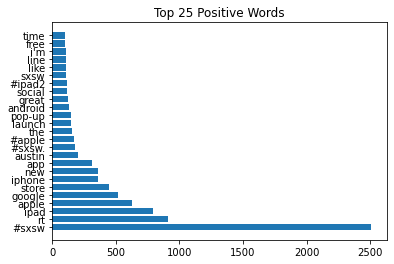

In [25]:
plt.barh(positive_25[0], positive_25[1])
plt.title('Top 25 Positive Words')
#plt.savefig('top_positive_words.png')
plt.show()

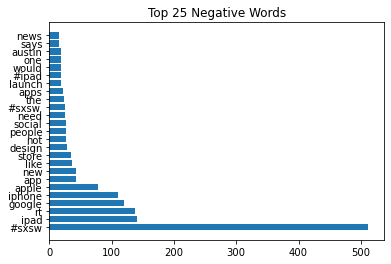

In [26]:
plt.barh(negative_25[0], negative_25[1])
plt.title('Top 25 Negative Words')
#plt.savefig('top_negative_words.png')
plt.show()

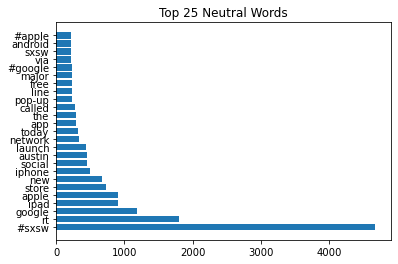

In [27]:
plt.barh(neutral_25[0], neutral_25[1])
plt.title('Top 25 Neutral Words')
#plt.savefig('top_neutral_words.png')
plt.show()

### Word Clouds

In [29]:
positive_bar_counts = [x[1] for x in positive_freq.most_common(25)]
positive_bar_words  = [x[0] for x in positive_freq.most_common(25)]

negative_bar_counts = [x[1] for x in negative_freq.most_common(25)]
negative_bar_words  = [x[0] for x in negative_freq.most_common(25)]

neutral_bar_counts  = [x[1] for x in neutral_freq.most_common(25)]
neutral_bar_words   = [x[0] for x in neutral_freq.most_common(25)]

In [30]:
positive_dictionary = dict(zip(positive_bar_words, positive_bar_counts))
negative_dictionary = dict(zip(negative_bar_words, negative_bar_counts))
neutral_dictionary  = dict(zip(neutral_bar_words, neutral_bar_counts))

#### Positive Word Cloud

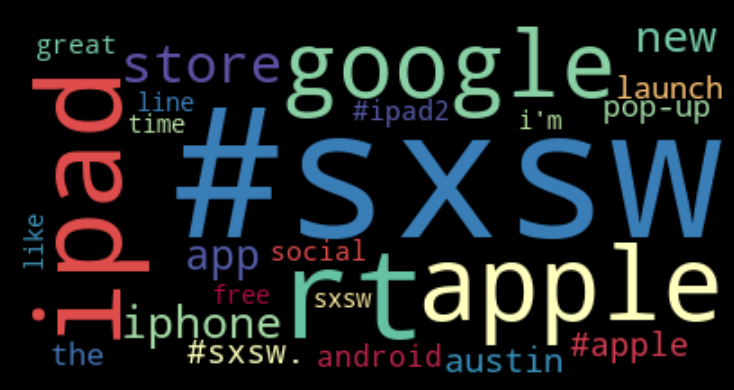

In [31]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(positive_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Word Cloud')
plt.tight_layout(pad=0)

#plt.savefig('positive_wordcloud.png')

plt.show()

#### Negative Word Cloud

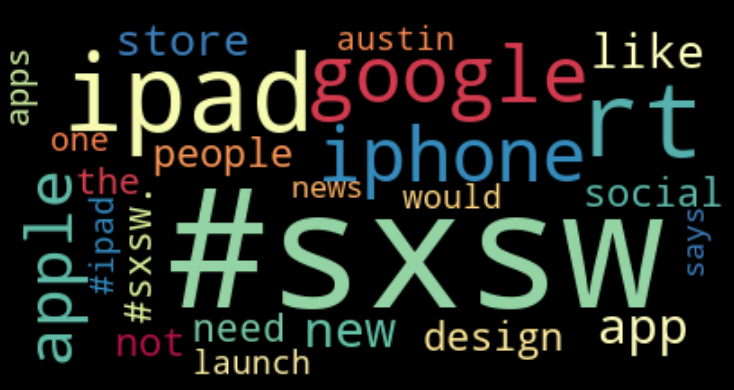

In [32]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(negative_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Word Cloud')
plt.tight_layout(pad=0)

#plt.savefig('negative_wordcloud.png')

plt.show()

#### Neutral Word Cloud

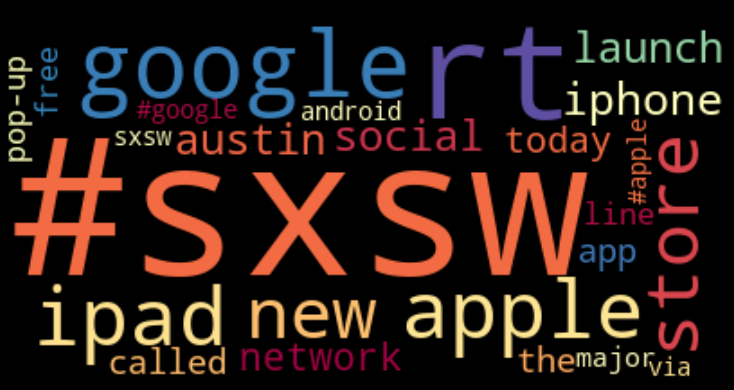

In [33]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(neutral_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Neutral Word Cloud')
plt.tight_layout(pad=0)

#plt.savefig('neutral_wordcloud.png')

plt.show()

# Binary Data Instantiations

We instantiated the binary data in various forms to see which would perform best in our models.

In [34]:
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

### Binary Data Lemmatization

In [35]:
data   = df['tweet_text']
target = df['is_there_an_emotion_directed_at_a_brand_or_product']

processed_data = [d.split() for d in data.to_list()]

lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

### Binary Lemmatized Data

In [36]:
X_lem = lemmatized_output
y_lem = target

### Bi Train-Test-Split with Tfidf Vectorizer

In [37]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)

tfidf = TfidfVectorizer(stop_words=sw_set)

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem  = tfidf.transform(X_test_lem)

#### Average Number Of Elements And Matrix Sparsity

In [38]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 10.45983086680761
Percentage of columns containing ZERO: 0.9979877201102717


### Binary SpaCy Data

In [39]:
nlp         = spacy.load('en_core_web_md')
df['spacy'] = df.tweet_text.apply(lambda x: nlp(x))

spacy_out_bi     = pd.DataFrame(np.vstack([x.vector for x in df.spacy]))
spacey_target_bi = df.is_there_an_emotion_directed_at_a_brand_or_product

spacey_target_bi.loc[(spacey_target_bi == "Negative emotion")] = -1
spacey_target_bi.loc[(spacey_target_bi == "Positive emotion")] =  1

spacey_target_bi = spacey_target_bi.astype(int)

### Binary SpaCy Train-Test-Split

In [40]:
X_spa_bi_train, X_spa_bi_test, y_spa_bi_train, y_spa_bi_test = train_test_split(spacy_out_bi, spacey_target_bi, 
                                                                    test_size=0.20, random_state=1)

## Binary Data Seperability

From our intial EDA it was clear that we had a large imbalance in our catagories. We created a scatterplot to check for seperability. Unfortunatly no seperability exisited.

### PCA Transformation

In [41]:
tfidf = TfidfVectorizer(stop_words=sw_set)

X_bi_tfidf = tfidf.fit_transform(X_lem)
X_bi_tfidf = X_bi_tfidf.toarray()

pca = PCA(n_components=2)

X_bi_pca = pca.fit_transform(X_bi_tfidf)
X_bi_pca = pd.DataFrame(X_bi_pca, columns=['PC1', 'PC2'])
X_bi_pca['Target'] = y

Text(0.5, 1.0, 'Binary Data Seperability')

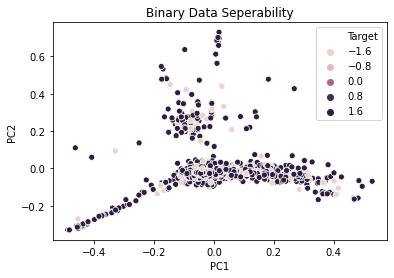

In [42]:
sns.scatterplot(x=X_bi_pca['PC1'], y=X_bi_pca['PC2'], 
                hue=X_bi_pca['Target']).set_title('Binary Data Seperability')

### Dense Data

In [43]:
train = tfidf_data_train_lem.toarray()
test  = tfidf_data_test_lem.toarray()

## TomekLinks

### PCA With 50 Components For Use With TomekLinks

In [105]:
bi_tfidf_link = TfidfVectorizer(stop_words=sw_set)

X_bi_tfidf_link = bi_tfidf_link.fit_transform(X_lem)
X_bi_tfidf_link = X_bi_tfidf_link.toarray()


bi_pca_for_link = PCA(n_components=50)

X_bi_pca_link = bi_pca_for_link.fit_transform(X_bi_tfidf_link)
X_bi_pca_link = pd.DataFrame(X_bi_pca_link)
X_bi_pca_link['y_bi'] = y_lem

In [110]:
X_bi_pca_link.loc[(X_bi_pca_link.y_bi == 'Negative emotion'), 'y_bi'] = -1
X_bi_pca_link.loc[(X_bi_pca_link.y_bi == 'Positive emotion'), 'y_bi'] = 1

In [111]:
X_bi_pca_link       = X_bi_pca_link.dropna()
X_bi_pca_link.y_bi = X_bi_pca_link.y_bi.astype(int)

X_bi_pca_link.dropna(axis=0, inplace=True)

In [112]:
X_tl_bi = X_bi_pca_link.drop('y_bi', axis=1).to_numpy()
y_tl_bi = X_bi_pca_link['y_bi'].to_numpy()

### SMOTETomek

In [113]:
tl_bi = SMOTETomek(tomek=TomekLinks(), sampling_strategy='not minority')
X_res_bi, y_res_bi = tl_bi.fit_resample(X_tl_bi, y_tl_bi)

### TomeklLinks

In [114]:
tl2_bi = TomekLinks()
X2_res_bi, y2_res_bi = tl2_bi.fit_resample(X_tl_bi, y_tl_bi)

### SMOTETomek Data

In [115]:
X_res_bi_df = pd.DataFrame(X_res_bi)
y_res_bi_df = pd.Series(y_res_bi)

### SMOTETomek Train-Test-Split

In [116]:
X_res_bi_train, X_res_bi_test, y_res_bi_train, y_res_bi_test = train_test_split(X_res_bi_df, y_res_bi_df, 
                                                                    test_size=0.20, random_state=1)

### TomekLinks Data

In [117]:
X2_res_bi_df = pd.DataFrame(X2_res_bi)
y2_res_bi_df = pd.Series(y2_res_bi)

### TomekLinks Train-Test-Split

In [118]:
X2_res_bi_train, X2_res_bi_test, y2_res_bi_train, y2_res_bi_test = train_test_split(X2_res_bi_df, y2_res_bi_df, 
                                                                    test_size=0.20, random_state=1)

# Binary Data Modeling

We began our binary modeling with a Gausian Naive Bayes as our initial benchmark but quickly realized that Random Forest was a much better fit for the data we had.

### Bi Gausian Naive Bayes

In [44]:
gnb = GaussianNB()

In [45]:
gnb.fit(train, y_train_lem)

gnb_train_preds_lem = gnb.predict(train)
gnb_test_preds_lem  = gnb.predict(test)

print(classification_report(y_train_lem, gnb_train_preds_lem))
print(classification_report(y_test_lem, gnb_test_preds_lem))

                  precision    recall  f1-score   support

Negative emotion       0.66      1.00      0.80       459
Positive emotion       1.00      0.90      0.95      2379

        accuracy                           0.92      2838
       macro avg       0.83      0.95      0.87      2838
    weighted avg       0.95      0.92      0.92      2838

                  precision    recall  f1-score   support

Negative emotion       0.33      0.57      0.42       111
Positive emotion       0.91      0.78      0.84       599

        accuracy                           0.75       710
       macro avg       0.62      0.68      0.63       710
    weighted avg       0.82      0.75      0.77       710



### Bi SVM - SMOTETomek Data

In [120]:
weight_dict = {-1:50, 1:5}

svc_tom = SVC(kernel='rbf', C=1000, class_weight=weight_dict)

svc_tom.fit(X_res_bi_train, y_res_bi_train)

y_pred_bi_train = svc_tom.predict(X_res_bi_train)
y_pred_bi_test  = svc_tom.predict(X_res_bi_test)

print(classification_report(y_res_bi_train, y_pred_bi_train))
print(classification_report(y_res_bi_test, y_pred_bi_test))

              precision    recall  f1-score   support

          -1       0.91      1.00      0.95       196
           1       1.00      0.98      0.99       920

    accuracy                           0.98      1116
   macro avg       0.96      0.99      0.97      1116
weighted avg       0.98      0.98      0.98      1116

              precision    recall  f1-score   support

          -1       0.23      0.23      0.23        48
           1       0.84      0.84      0.84       231

    accuracy                           0.74       279
   macro avg       0.54      0.54      0.54       279
weighted avg       0.74      0.74      0.74       279



### Bi SVM - Tomek Data

In [121]:
weight_dict = {-1:50, 1:5}

svc_tom2 = SVC(kernel='rbf', C=1000, class_weight=weight_dict)

svc_tom2.fit(X2_res_bi_train, y2_res_bi_train)

y2_pred_bi_train = svc_tom2.predict(X2_res_bi_train)
y2_pred_bi_test  = svc_tom2.predict(X2_res_bi_test)

print(classification_report(y2_res_bi_train, y2_pred_bi_train))
print(classification_report(y2_res_bi_test, y2_pred_bi_test))

              precision    recall  f1-score   support

          -1       0.91      1.00      0.95       193
           1       1.00      0.98      0.99       927

    accuracy                           0.98      1120
   macro avg       0.96      0.99      0.97      1120
weighted avg       0.98      0.98      0.98      1120

              precision    recall  f1-score   support

          -1       0.21      0.29      0.25        51
           1       0.83      0.76      0.79       229

    accuracy                           0.68       280
   macro avg       0.52      0.53      0.52       280
weighted avg       0.72      0.68      0.69       280



### Binary SVM with SpaCy Data

In [46]:
weight_dict = {-1:50, 1:5}

svc_spa_bi = SVC(kernel='rbf', C=1000, class_weight=weight_dict)

svc_spa_bi.fit(X_spa_bi_train, y_spa_bi_train)

y_pred_train = svc_spa_bi.predict(X_spa_bi_train)
y_pred_test  = svc_spa_bi.predict(X_spa_bi_test)

print(classification_report(y_spa_bi_train, y_pred_train))
print(classification_report(y_spa_bi_test, y_pred_test))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       459
           1       1.00      1.00      1.00      2379

    accuracy                           1.00      2838
   macro avg       1.00      1.00      1.00      2838
weighted avg       1.00      1.00      1.00      2838

              precision    recall  f1-score   support

          -1       0.54      0.49      0.51       111
           1       0.91      0.92      0.91       599

    accuracy                           0.85       710
   macro avg       0.72      0.70      0.71       710
weighted avg       0.85      0.85      0.85       710



### Binary Gaussian Naive Bayes - SpaCy Data

In [47]:
gnb_spa_bi = GaussianNB()

gnb_spa_bi.fit(X_spa_bi_train, y_spa_bi_train)

gnb_train_preds_spa_bi = gnb_spa_bi.predict(X_spa_bi_train)
gnb_test_preds_spa_bi  = gnb_spa_bi.predict(X_spa_bi_test)

print(classification_report(y_spa_bi_train, gnb_train_preds_spa_bi))
print(classification_report(y_spa_bi_test, gnb_test_preds_spa_bi))

              precision    recall  f1-score   support

          -1       0.30      0.76      0.44       459
           1       0.94      0.66      0.78      2379

    accuracy                           0.68      2838
   macro avg       0.62      0.71      0.61      2838
weighted avg       0.83      0.68      0.72      2838

              precision    recall  f1-score   support

          -1       0.28      0.75      0.40       111
           1       0.93      0.64      0.76       599

    accuracy                           0.65       710
   macro avg       0.60      0.69      0.58       710
weighted avg       0.83      0.65      0.70       710



### Binary Random Forest Classifier - SpaCy Data

In [48]:
weight_dict = {-1:10, 1:1}

rfc_spa_bi = RandomForestClassifier(class_weight=weight_dict)

rfc_spa_bi.fit(X_spa_bi_train, y_spa_bi_train)

rf_train_preds_spa_bi = rfc_spa_bi.predict(X_spa_bi_train)
rf_test_preds_spa_bi  = rfc_spa_bi.predict(X_spa_bi_test)

print(classification_report(y_spa_bi_train, rf_train_preds_spa_bi))
print(classification_report(y_spa_bi_test, rf_test_preds_spa_bi))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       459
           1       1.00      1.00      1.00      2379

    accuracy                           1.00      2838
   macro avg       1.00      1.00      1.00      2838
weighted avg       1.00      1.00      1.00      2838

              precision    recall  f1-score   support

          -1       0.78      0.13      0.22       111
           1       0.86      0.99      0.92       599

    accuracy                           0.86       710
   macro avg       0.82      0.56      0.57       710
weighted avg       0.85      0.86      0.81       710



### Binary Random Forest Classifier - SMOTETomek Data

In [122]:
weight_dict = {-1:100, 1:1}

rfc_tom_bi = RandomForestClassifier(class_weight=weight_dict)

rfc_tom_bi.fit(X_res_bi_train, y_res_bi_train)

rf_train_preds_tom_bi = rfc_tom_bi.predict(X_res_bi_train)
rf_test_preds_tom_bi  = rfc_tom_bi.predict(X_res_bi_test)

print(classification_report(y_res_bi_train, rf_train_preds_tom_bi))
print(classification_report(y_res_bi_test, rf_test_preds_tom_bi))

              precision    recall  f1-score   support

          -1       0.92      0.99      0.95       196
           1       1.00      0.98      0.99       920

    accuracy                           0.98      1116
   macro avg       0.96      0.99      0.97      1116
weighted avg       0.98      0.98      0.98      1116

              precision    recall  f1-score   support

          -1       0.50      0.06      0.11        48
           1       0.84      0.99      0.90       231

    accuracy                           0.83       279
   macro avg       0.67      0.52      0.51       279
weighted avg       0.78      0.83      0.77       279



### Binary Random Forest Classifier - Tomek Data

In [123]:
weight_dict = {-1:100, 1:1}

rfc_tom2_bi = RandomForestClassifier(class_weight=weight_dict)

rfc_tom2_bi.fit(X2_res_bi_train, y2_res_bi_train)

rf_train_preds_tom2_bi = rfc_tom2_bi.predict(X2_res_bi_train)
rf_test_preds_tom2_bi  = rfc_tom2_bi.predict(X2_res_bi_test)

print(classification_report(y2_res_bi_train, rf_train_preds_tom2_bi))
print(classification_report(y2_res_bi_test, rf_test_preds_tom2_bi))

              precision    recall  f1-score   support

          -1       0.91      1.00      0.95       193
           1       1.00      0.98      0.99       927

    accuracy                           0.98      1120
   macro avg       0.96      0.99      0.97      1120
weighted avg       0.98      0.98      0.98      1120

              precision    recall  f1-score   support

          -1       0.15      0.04      0.06        51
           1       0.82      0.95      0.88       229

    accuracy                           0.79       280
   macro avg       0.49      0.50      0.47       280
weighted avg       0.70      0.79      0.73       280



### Binary Random Forest Classifier - Gridsearch: SpaCy Data

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Random Forest Classifier Train Report:

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       459
           1       1.00      1.00      1.00      2379

    accuracy                           1.00      2838
   macro avg       1.00      1.00      1.00      2838
weighted avg       1.00      1.00      1.00      2838

Random Forest Classifier Test Report:

              precision    recall  f1-score   support

          -1       0.91      0.09      0.16       111
           1       0.86      1.00      0.92       599

    accuracy                           0.86       710
   macro avg       0.88      0.54      0.54       710
weighted avg       0.86      0.86      0.80       710

Random Forest Classifier Train Data Confusion Matrix:



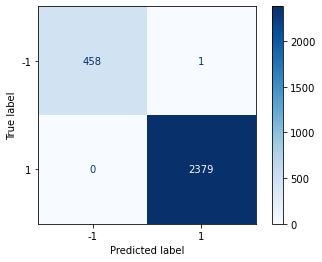

Random Forest Classifier Test Data Confusion Matrix:



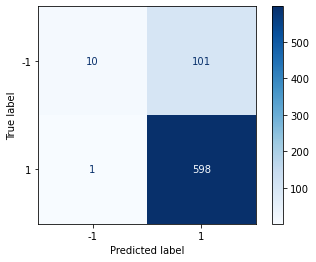

In [49]:
rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [10, 15, 20, 25, 30, 35]}

rfc_spa_grid_bi = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='f1_weighted',
                                return_train_score=True, verbose=1, n_jobs=-1)

rfc_spa_grid_bi.fit(X_spa_bi_train, y_spa_bi_train)

rfc_train_preds_spa_grid_bi = rfc_spa_grid_bi.predict(X_spa_bi_train)
rfc_test_preds_spa_grid_bi  = rfc_spa_grid_bi.predict(X_spa_bi_test)

print('\033[1m' + 'Random Forest Classifier Train Report:\n' + '\033[0m')
print(classification_report(y_spa_bi_train, rfc_train_preds_spa_grid_bi))
print('\033[1m' + 'Random Forest Classifier Test Report:\n' + '\033[0m')
print(classification_report(y_spa_bi_test, rfc_test_preds_spa_grid_bi))

print('\033[1m' + 'Random Forest Classifier Train Data Confusion Matrix:\n')
plot_confusion_matrix(rfc_spa_grid_bi, X_spa_bi_train, y_spa_bi_train, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Random Forest Classifier Test Data Confusion Matrix:\n')
plot_confusion_matrix(rfc_spa_grid_bi, X_spa_bi_test, y_spa_bi_test, cmap=plt.cm.Blues)
plt.show()

### Bi Random Forest Classifier - Tfidf

Since we had such a profound class imbalance we decided to correct it by playing with different weight ratios for our classes. After extensive modeling we landed on a 10 to 1 weight for the negative class which gave us our best results.

In [50]:
weight_dict = {'Negative emotion':10, 'Positive emotion':1}

rfc_lem_bi  = RandomForestClassifier(class_weight=weight_dict)

In [51]:
rfc_lem_bi.fit(tfidf_data_train_lem, y_train_lem)

rf_train_preds_lem_bi = rfc_lem_bi.predict(tfidf_data_train_lem)
rf_test_preds_lem_bi  = rfc_lem_bi.predict(tfidf_data_test_lem)

print(classification_report(y_train_lem, rf_train_preds_lem_bi))
print(classification_report(y_test_lem, rf_test_preds_lem_bi))

                  precision    recall  f1-score   support

Negative emotion       0.99      1.00      0.99       459
Positive emotion       1.00      1.00      1.00      2379

        accuracy                           1.00      2838
       macro avg       0.99      1.00      1.00      2838
    weighted avg       1.00      1.00      1.00      2838

                  precision    recall  f1-score   support

Negative emotion       0.73      0.32      0.45       111
Positive emotion       0.89      0.98      0.93       599

        accuracy                           0.88       710
       macro avg       0.81      0.65      0.69       710
    weighted avg       0.86      0.88      0.86       710



Random Forest Classifier Train Data Confusion Matrix:



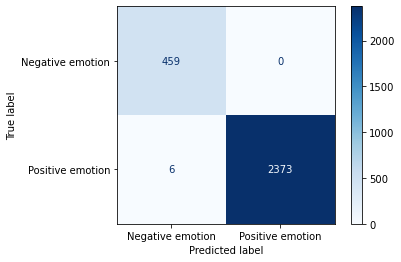

Random Forest Classifier Test Data Confusion Matrix:



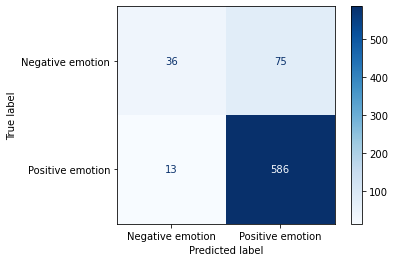

In [52]:
print('\033[1m' + 'Random Forest Classifier Train Data Confusion Matrix:\n')
plot_confusion_matrix(rfc_lem_bi, tfidf_data_train_lem, y_train_lem, cmap=plt.cm.Blues)
#plt.savefig('rfc_train_matrix.png')
plt.show()
print('\033[1m' + 'Random Forest Classifier Test Data Confusion Matrix:\n')
plot_confusion_matrix(rfc_lem_bi, tfidf_data_test_lem, y_test_lem, cmap=plt.cm.Blues)
#plt.savefig('rfc_test_matrix.png')
plt.show()

#### Feature Importances

Once we found our best model we extracted the most important features and stumbled on some very interesting insights.

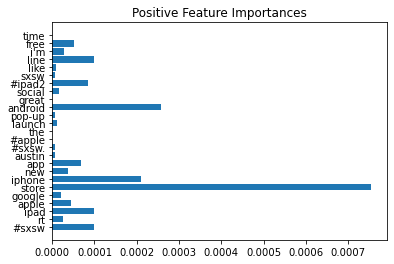

In [53]:
plt.barh(positive_25[0], rfc_lem_bi.feature_importances_[:25])
plt.title('Positive Feature Importances')
#plt.savefig('positive_fi.png')
plt.show()

It became clear that Apple was the main driving factor in positive classification.

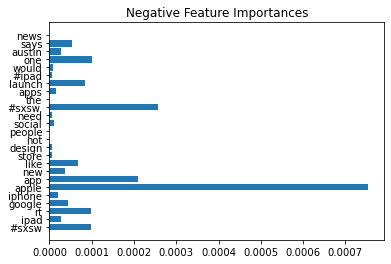

In [54]:
plt.barh(negative_25[0], rfc_lem_bi.feature_importances_[:25])
plt.title('Negative Feature Importances')
plt.savefig('negative_fi.png')
plt.show()

While at the same time it became clear that Google was the main driving factor in negative classification.

### Bi Random Forest Classifier - Gridsearch: Tfidf

We attempted to further refine our RFC model with a Gridsearch but were unable to surpass 88% accuracy rate of our weighted RFC model. 

In [55]:
rfc_grid = {'n_estimators': [200,300], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [70, 80]}

rfc_lem_grid_bi = GridSearchCV(RandomForestClassifier(), rfc_grid, 
                               scoring='recall', return_train_score=True, 
                               verbose=1, n_jobs=-1)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/jojo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/home/jojo/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Random Forest Classifier Train Report:

                  precision    recall  f1-score   support

Negative emotion       1.00      0.49      0.66       459
Positive emotion       0.91      1.00      0.95      2379

        accuracy                           0.92      2838
       macro avg       0.96      0.75      0.81      2838
    weighted avg       0.92      0.92      0.91      2838

Random Forest Classifier Test Report:

                  precision    recall  f1-score   support

Negative emotion       0.91      0.09      0.16       111
Positive emotion       0.86      1.00      0.92       599

        accuracy                           0.86       710
       macro avg       0.88      0.54      0.54       710
    weighted avg       0.86      0.86      0.80       710

Random Forest Classifier Train Data Confusion Matrix:



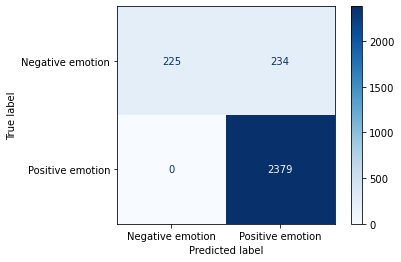

Random Forest Classifier Test Data Confusion Matrix:



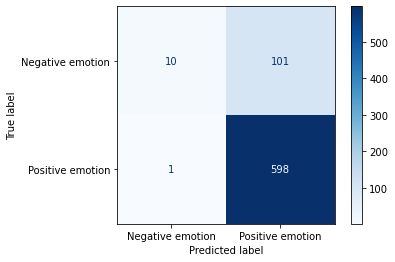

In [56]:
rfc_lem_grid_bi.fit(tfidf_data_train_lem, y_train_lem)

rfc_train_preds_lem_grid_bi = rfc_lem_grid_bi.predict(tfidf_data_train_lem)
rfc_test_preds_lem_grid_bi  = rfc_lem_grid_bi.predict(tfidf_data_test_lem)

print('\033[1m' + 'Random Forest Classifier Train Report:\n' + '\033[0m')
print(classification_report(y_train_lem, rfc_train_preds_lem_grid_bi))
print('\033[1m' + 'Random Forest Classifier Test Report:\n' + '\033[0m')
print(classification_report(y_test_lem, rfc_test_preds_lem_grid_bi))

print('\033[1m' + 'Random Forest Classifier Train Data Confusion Matrix:\n')
plot_confusion_matrix(rfc_lem_grid_bi, tfidf_data_train_lem, y_train_lem, cmap=plt.cm.Blues)
plt.savefig('rfc_g_train_matrix.png')
plt.show()
print('\033[1m' + 'Random Forest Classifier Test Data Confusion Matrix:\n')
plot_confusion_matrix(rfc_lem_grid_bi, tfidf_data_test_lem, y_test_lem, cmap=plt.cm.Blues)
plt.savefig('rfc_g_test_matrix.png')
plt.show()

# Ternary Data Instantiations

In order to maximize our insights we attempted various versions of postive, negative, and neutral catagories for our models.

### Ternary Data Lemmatization

In [57]:
data_tri   = df_tri['tweet_text']
target_tri = df_tri['is_there_an_emotion_directed_at_a_brand_or_product'] 

processed_data = [d.split() for d in data_tri.to_list()]

lemmatized_output_tri = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output_tri.append(lemmed)

### Lemmatized Ternary Data

In [58]:
X_tri = lemmatized_output_tri
y_tri = target_tri

### Tri Tfidf Train-Test-Split

In [59]:
X_train_lem_tri, X_test_lem_tri, y_train_lem_tri, y_test_lem_tri = train_test_split(X_tri, y_tri, test_size=0.20, random_state=1)

tfidf = TfidfVectorizer(stop_words=sw_set)

tfidf_data_train_lem_tri = tfidf.fit_transform(X_train_lem_tri)
tfidf_data_test_lem_tri  = tfidf.transform(X_test_lem_tri)

In [60]:
tfidf_data_train_lem_tri.shape

(7148, 8539)

### Ternary SpaCy Data

In [61]:
nlp             = spacy.load('en_core_web_md')
df_tri['spacy'] = df_tri.tweet_text.apply(lambda x: nlp(x))

spacy_output  = pd.DataFrame(np.vstack([x.vector for x in df_tri.spacy]))

spacey_target = df_tri.is_there_an_emotion_directed_at_a_brand_or_product
spacey_target.loc[(spacey_target == "Negative emotion")]                   = -1
spacey_target.loc[(spacey_target == "Positive emotion")]                   = 1
spacey_target.loc[(spacey_target == "No emotion toward brand or product")] = 0

spacey_target = spacey_target.astype(int)

### Tri SpaCy Train-Test-Split 

In [62]:

X_spa_train, X_spa_test, y_spa_train, y_spa_test = train_test_split(spacy_output, spacey_target, 
                                                                    test_size=0.20, random_state=1)


## Ternary Data Seperability

In [63]:
tfidf = TfidfVectorizer(stop_words=sw_set)

X_tri_tfidf_sep = tfidf.fit_transform(X_tri)
X_tri_tfidf_sep = X_tri_tfidf_sep.toarray()

pca = PCA(n_components=2)

X_tri_pca = pca.fit_transform(X_tri_tfidf_sep)
X_tri_pca = pd.DataFrame(X_tri_pca, columns=['PC1', 'PC2'])
X_tri_pca['Target'] = y_tri

Text(0.5, 1.0, 'Data Seperability')

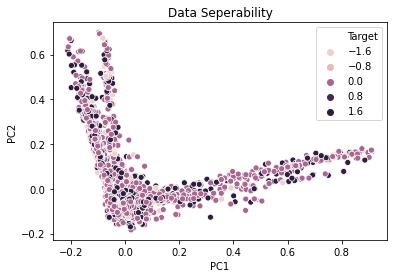

In [64]:
sns.scatterplot(x=X_tri_pca['PC1'], y=X_tri_pca['PC2'],
                hue=X_tri_pca['Target']).set_title('Data Seperability')

## TomekLinks

### PCA With 50 Components For Use With TomekLinks

In [99]:
tfidf_link = TfidfVectorizer(stop_words=sw_set)

X_tri_tfidf_link = tfidf_link.fit_transform(X_tri)
X_tri_tfidf_link = X_tri_tfidf_link.toarray()


pca_for_link = PCA(n_components=50)

X_tri_pca_link = pca_for_link.fit_transform(X_tri_tfidf_link)
X_tri_pca_link = pd.DataFrame(X_tri_pca_link)
X_tri_pca_link['y_tri'] = y_tri

In [100]:
X_tri_pca_link.loc[(X_tri_pca_link.y_tri == 'Negative emotion'), 'y_tri'] = -1
X_tri_pca_link.loc[(X_tri_pca_link.y_tri == 'Positive emotion'), 'y_tri'] = 1
X_tri_pca_link.loc[(X_tri_pca_link.y_tri == 'No emotion toward brand or product'), 'y_tri'] = 0

In [101]:
X_tri_pca_link       = X_tri_pca_link.dropna()
X_tri_pca_link.y_tri = X_tri_pca_link.y_tri.astype(int)

X_tri_pca_link.dropna(axis=0, inplace=True)

In [102]:
X_tl = X_tri_pca_link.drop('y_tri', axis=1).to_numpy()
y_tl = X_tri_pca_link['y_tri'].to_numpy()

In [103]:
tl = SMOTETomek(tomek=TomekLinks(), sampling_strategy='not minority')
X_res, y_res = tl.fit_resample(X_tl, y_tl)

In [104]:
tl2            = TomekLinks()
X2_res, y2_res = tl2.fit_resample(X_tl, y_tl)

## SMOTETomek Data

In [75]:
X_res_df = pd.DataFrame(X_res)
y_res_df = pd.Series(y_res)

## SMOTETomek Train-Test-Split

In [76]:

X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res_df, y_res_df, 
                                                                    test_size=0.20, random_state=1)


# Ternary Data Modeling

By using various techniques for vectorizing our data we got some pretty good accuracy even though the amount of neutral tweets was far greater then any other class.

### Tri SVC - SMOTETomek Data

In [77]:
weight_dict = {-1:50, 0:1, 1:5}

svc_tom = SVC(kernel='rbf', C=1000, class_weight=weight_dict)

In [78]:
svc_tom.fit(X_res_train, y_res_train)

y_pred_train = svc_tom.predict(X_res_train)
y_pred_test  = svc_tom.predict(X_res_test)

print(classification_report(y_res_train, y_pred_train))
print(classification_report(y_res_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.60      1.00      0.75       459
           0       1.00      0.78      0.88      3852
           1       0.85      0.97      0.91      3946

    accuracy                           0.88      8257
   macro avg       0.82      0.92      0.85      8257
weighted avg       0.91      0.88      0.89      8257

              precision    recall  f1-score   support

          -1       0.10      0.25      0.14       105
           0       0.71      0.48      0.57       998
           1       0.62      0.73      0.67       962

    accuracy                           0.58      2065
   macro avg       0.48      0.49      0.46      2065
weighted avg       0.64      0.58      0.60      2065



### Tri SVC - SpaCy Data

In [79]:
weight_dict = {-1:50, 0:1, 1:5}

svc_spa_clf = SVC(kernel='rbf', C=1000, class_weight=weight_dict)

In [80]:
svc_spa_clf.fit(X_spa_train, y_spa_train)

y_pred_train = svc_spa_clf.predict(X_spa_train)
y_pred_test  = svc_spa_clf.predict(X_spa_test)

print(classification_report(y_spa_train, y_pred_train))
print(classification_report(y_spa_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       473
           0       1.00      0.97      0.98      4295
           1       0.95      1.00      0.97      2380

    accuracy                           0.98      7148
   macro avg       0.97      0.99      0.98      7148
weighted avg       0.98      0.98      0.98      7148

              precision    recall  f1-score   support

          -1       0.33      0.46      0.39        97
           0       0.74      0.69      0.72      1093
           1       0.55      0.59      0.57       598

    accuracy                           0.64      1788
   macro avg       0.54      0.58      0.56      1788
weighted avg       0.66      0.64      0.65      1788



### Tri Gausian Naive Bayes - Tfidf Data

In [81]:
train = tfidf_data_train_lem_tri.toarray()
test  = tfidf_data_test_lem_tri.toarray()

In [82]:
gnb_tri = GaussianNB()

In [83]:
gnb_tri.fit(train, y_train_lem_tri)

gnb_train_preds_lem_tri = gnb_tri.predict(train)
gnb_test_preds_lem_tri  = gnb_tri.predict(test)

print(classification_report(y_train_lem_tri, gnb_train_preds_lem_tri))
print(classification_report(y_test_lem_tri, gnb_test_preds_lem_tri))

                                    precision    recall  f1-score   support

                  Negative emotion       0.37      1.00      0.54       473
No emotion toward brand or product       1.00      0.58      0.74      4295
                  Positive emotion       0.64      0.91      0.75      2380

                          accuracy                           0.72      7148
                         macro avg       0.67      0.83      0.68      7148
                      weighted avg       0.84      0.72      0.73      7148

                                    precision    recall  f1-score   support

                  Negative emotion       0.13      0.46      0.20        97
No emotion toward brand or product       0.73      0.39      0.50      1093
                  Positive emotion       0.44      0.63      0.52       598

                          accuracy                           0.47      1788
                         macro avg       0.43      0.49      0.41      1788
       

### Tri Gaussian Naive Bayes - SpaCy Data

In [84]:
gnb_spa_tri = GaussianNB()

In [85]:
gnb_spa_tri.fit(X_spa_train, y_spa_train)

gnb_train_preds_spa_tri = gnb_spa_tri.predict(X_spa_train)
gnb_test_preds_spa_tri  = gnb_spa_tri.predict(X_spa_test)

print(classification_report(y_spa_train, gnb_train_preds_spa_tri))
print(classification_report(y_spa_test, gnb_test_preds_spa_tri))

              precision    recall  f1-score   support

          -1       0.15      0.72      0.24       473
           0       0.73      0.56      0.63      4295
           1       0.52      0.33      0.41      2380

    accuracy                           0.49      7148
   macro avg       0.47      0.54      0.43      7148
weighted avg       0.62      0.49      0.53      7148

              precision    recall  f1-score   support

          -1       0.12      0.72      0.21        97
           0       0.75      0.56      0.64      1093
           1       0.52      0.36      0.42       598

    accuracy                           0.50      1788
   macro avg       0.46      0.54      0.42      1788
weighted avg       0.64      0.50      0.54      1788



### Tri Random Forest Classifier - Tfidf Data

Our best neutral model was the RFC with Tfidf vectorizer with a 20x2x1 weight ratio.|

In [86]:
weight_dict = {'Negative emotion':20, 'No emotion toward brand or product':1,
               'Positive emotion':2}

rf_classifier_lem_tri = RandomForestClassifier(class_weight=weight_dict)

In [87]:
rf_classifier_lem_tri.fit(tfidf_data_train_lem_tri, y_train_lem_tri)

rf_train_preds_lem_tri = rf_classifier_lem_tri.predict(tfidf_data_train_lem_tri)
rf_test_preds_lem_tri  = rf_classifier_lem_tri.predict(tfidf_data_test_lem_tri)

print(classification_report(y_train_lem_tri, rf_train_preds_lem_tri))
print(classification_report(y_test_lem_tri, rf_test_preds_lem_tri))

                                    precision    recall  f1-score   support

                  Negative emotion       0.92      1.00      0.96       473
No emotion toward brand or product       0.98      0.95      0.97      4295
                  Positive emotion       0.92      0.97      0.95      2380

                          accuracy                           0.96      7148
                         macro avg       0.94      0.97      0.96      7148
                      weighted avg       0.96      0.96      0.96      7148

                                    precision    recall  f1-score   support

                  Negative emotion       0.63      0.33      0.43        97
No emotion toward brand or product       0.70      0.86      0.78      1093
                  Positive emotion       0.64      0.43      0.51       598

                          accuracy                           0.69      1788
                         macro avg       0.66      0.54      0.57      1788
       

#### Feature Importances

Text(0.5, 1.0, 'Positive Feature Importances')

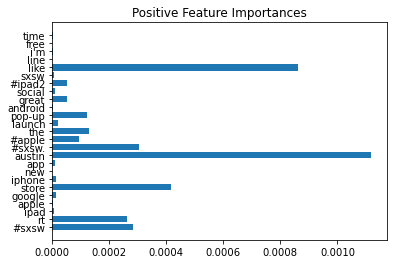

In [88]:
plt.barh(positive_25[0], rf_classifier_lem_tri.feature_importances_[:25])
plt.title('Positive Feature Importances')
#plt.savefig('tri_rfc_positive_fi.png')

Text(0.5, 1.0, 'Negative Feature Importances')

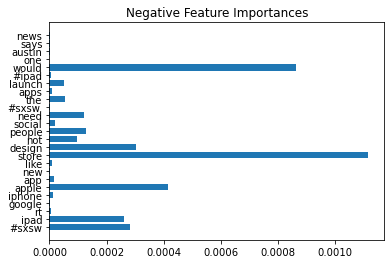

In [89]:
plt.barh(negative_25[0], rf_classifier_lem_tri.feature_importances_[:25])
plt.title('Negative Feature Importances')
#plt.savefig('tri_rfc_negative_fi.png')

Text(0.5, 1.0, 'Neutral Feature Importances')

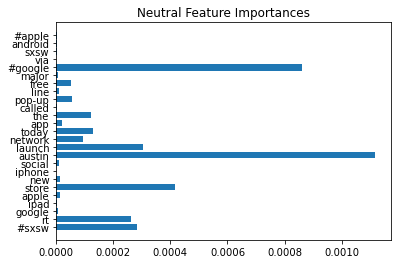

In [90]:
plt.barh(neutral_25[0], rf_classifier_lem_tri.feature_importances_[:25])
plt.title('Neutral Feature Importances')
#plt.savefig('tri_rfc_neutral_fi.png')

### Tri Random Forest Classifier - SpaCy Data

In [91]:
weight_dict = {-1:50, 0:1, 1:5}

rfc_spa_tri = RandomForestClassifier(class_weight=weight_dict)

In [92]:
rfc_spa_tri.fit(X_spa_train, y_spa_train)

rf_train_preds_spa_tri = rfc_spa_tri.predict(X_spa_train)
rf_test_preds_spa_tri  = rfc_spa_tri.predict(X_spa_test)

print(classification_report(y_spa_train, rf_train_preds_spa_tri))
print(classification_report(y_spa_test, rf_test_preds_spa_tri))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       473
           0       1.00      1.00      1.00      4295
           1       0.99      1.00      1.00      2380

    accuracy                           1.00      7148
   macro avg       1.00      1.00      1.00      7148
weighted avg       1.00      1.00      1.00      7148

              precision    recall  f1-score   support

          -1       0.57      0.13      0.22        97
           0       0.67      0.92      0.77      1093
           1       0.66      0.29      0.40       598

    accuracy                           0.66      1788
   macro avg       0.63      0.45      0.46      1788
weighted avg       0.66      0.66      0.62      1788



### Tri Random Forest Classifier - SMOTETomek Data

In [93]:
weight_dict = {-1:100, 0:1, 1:1}

rfc_tom_tri = RandomForestClassifier(class_weight=weight_dict)

In [94]:
rfc_tom_tri.fit(X_res_train, y_res_train)

rf_train_preds_tom_tri = rfc_tom_tri.predict(X_res_train)
rf_test_preds_tom_tri  = rfc_tom_tri.predict(X_res_test)

print(classification_report(y_res_train, rf_train_preds_tom_tri))
print(classification_report(y_res_test, rf_test_preds_tom_tri))

              precision    recall  f1-score   support

          -1       0.68      1.00      0.81       459
           0       0.96      0.93      0.94      3852
           1       0.96      0.94      0.95      3946

    accuracy                           0.94      8257
   macro avg       0.87      0.96      0.90      8257
weighted avg       0.94      0.94      0.94      8257

              precision    recall  f1-score   support

          -1       0.10      0.07      0.08       105
           0       0.67      0.65      0.66       998
           1       0.65      0.69      0.67       962

    accuracy                           0.64      2065
   macro avg       0.47      0.47      0.47      2065
weighted avg       0.63      0.64      0.64      2065



### Tri Random Forest Classifier - Gridsearch: SpaCy Data

In [95]:
rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [10, 15, 20, 25, 30, 35]}

rfc_spa_grid_tri = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='f1_weighted',
                                return_train_score=True, verbose=1, n_jobs=-1)


In [96]:
rfc_spa_grid_tri.fit(X_spa_train, y_spa_train)

rfc_train_preds_spa_grid_tri = rfc_spa_grid_tri.predict(X_spa_train)
rfc_test_preds_spa_grid_tri  = rfc_spa_grid_tri.predict(X_spa_test)

print(classification_report(y_spa_train, rfc_train_preds_spa_grid_tri))
print(classification_report(y_spa_test, rfc_test_preds_spa_grid_tri))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       473
           0       1.00      1.00      1.00      4295
           1       1.00      1.00      1.00      2380

    accuracy                           1.00      7148
   macro avg       1.00      1.00      1.00      7148
weighted avg       1.00      1.00      1.00      7148

              precision    recall  f1-score   support

          -1       0.67      0.08      0.15        97
           0       0.70      0.92      0.79      1093
           1       0.70      0.39      0.50       598

    accuracy                           0.70      1788
   macro avg       0.69      0.46      0.48      1788
weighted avg       0.70      0.70      0.66      1788



### Tri Random Forest Classifier - Gridsearch: Tfidf

In [97]:
rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [10, 15, 20, 25, 30, 35]}

rfc_lem_grid_tri = GridSearchCV(RandomForestClassifier(), rfc_grid, 
                                scoring='roc_auc_ovo_weighted', return_train_score=True, 
                                verbose=1, n_jobs=-1)


In [98]:
rfc_lem_grid_tri.fit(tfidf_data_train_lem_tri, y_train_lem_tri)

rfc_train_preds_lem_grid_tri = rfc_lem_grid_tri.predict(tfidf_data_train_lem_tri)
rfc_test_preds_lem_grid_tri  = rfc_lem_grid_tri.predict(tfidf_data_test_lem_tri)

print(classification_report(y_train_lem_tri, rfc_train_preds_lem_grid_tri))
print(classification_report(y_test_lem_tri, rfc_test_preds_lem_grid_tri))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
                                    precision    recall  f1-score   support

                  Negative emotion       1.00      0.09      0.17       473
No emotion toward brand or product       0.65      1.00      0.79      4295
                  Positive emotion       1.00      0.23      0.37      2380

                          accuracy                           0.68      7148
                         macro avg       0.88      0.44      0.44      7148
                      weighted avg       0.79      0.68      0.61      7148

                                    precision    recall  f1-score   support

                  Negative emotion       0.83      0.05      0.10        97
No emotion toward brand or product       0.64      0.99      0.77      1093
                  Positive emotion       0.82      0.12      0.22       598

                          accuracy                           0.65      1788
                     

## Conclusions And Next Steps

We can confidently say that based on our analysis the 2012 festival was a rousing success! By extracting individual words from our model we can see that Apple was particularly well received. We recommend prioritizing Apple next year for primetime panels and events. At the same time Google was a key driver of negative sentiment. While we can’t recommend banning the software giant outright, we would caution about how much time we would spend promoting their appearance at the next festival. On a more practical note, Pop-Up venues were unequivocally a big hit and should definitely be brought back and expanded on in the next year. There is certainly room for improvment in our existing models and further balancing of the classes in various ways can yield better results.

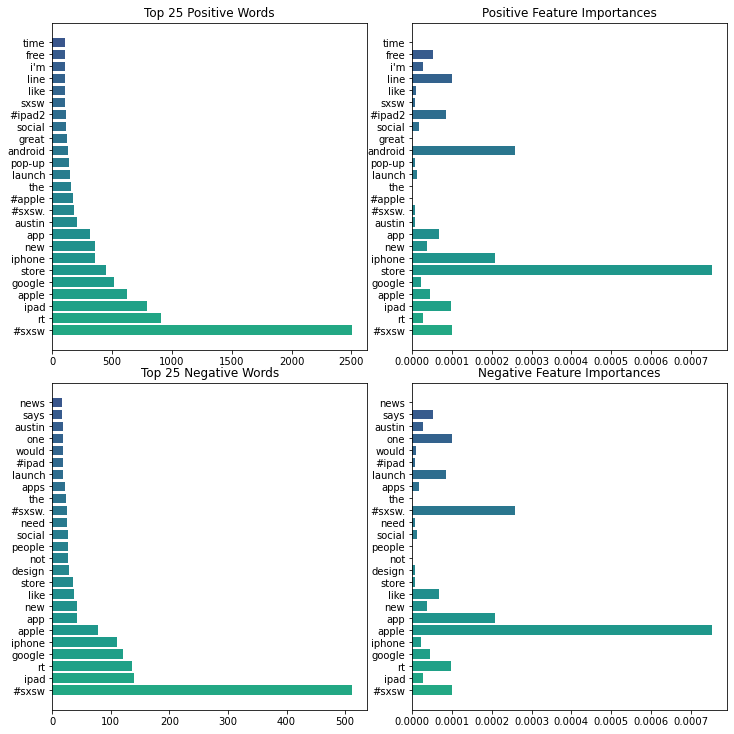

In [124]:
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
color = cm.viridis_r(np.linspace(.4,.8,30))
ax.barh(positive_25[0], positive_25[1], color=color)
ax2.barh(positive_25[0], rfc_lem_bi.feature_importances_[:25], color=color)
ax3.barh(negative_25[0], negative_25[1], color=color)
ax4.barh(negative_25[0], rfc_lem_bi.feature_importances_[:25], color=color)
ax.plot(colormap='PRGn')
ax.title.set_text('Top 25 Positive Words')
ax2.title.set_text('Positive Feature Importances')
ax3.title.set_text('Top 25 Negative Words')
ax4.title.set_text('Negative Feature Importances')
plt.tight_layout(pad=0)
#plt.savefig('word_count_bar_graphs.png')
plt.show()